In [1]:
import cv2
import scipy.stats
import numpy as np
from pathlib import Path
from PIL import Image
from pillow_heif import open_heif
import matplotlib.pyplot as plt
from skimage.measure import euler_number, label

In [2]:
def read_image(path, scale=1/4):
    try:
        if Path(path).suffix.lower() == ".heic":
            img = open_heif(path, convert_hdr_to_8bit=True)
        else:
            img = Image.open(path)
        rgb = np.asarray(img)
        H, W = rgb.shape[:-1]
        new_H = int(H * scale)
        new_W = int(W * scale)
    except:
        print(path)
        raise
    return cv2.resize(rgb, (new_W, new_H))

def extract_mask(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l = lab[:,:,0] / 255
    rb_mask = img[:,:,0] > img[:,:,2]
    bg_l = scipy.stats.mode(l.reshape(-1)).mode
    cont_mask = (np.abs(l - bg_l) / bg_l) * rb_mask
    return cont_mask


def extract_line(cont_mask, min_hole=10, max_hole=1000, max_res=0.25):
    kernel = np.ones((3,3),np.uint8)
    cs = np.arange(0.15, 1, .01)
    holes = np.zeros(len(cs))
    for i, c in enumerate(cs):
        cont_dab = ((cont_mask > c) * 255).astype(np.uint8)
        closing = cv2.morphologyEx(cont_dab, cv2.MORPH_CLOSE, kernel)
        e8 = euler_number(closing, connectivity=2)
        object_nb_8 = label(closing, connectivity=2).max()
        holes_nb_8 = object_nb_8 - e8
        holes[i] = holes_nb_8

    cond = (holes > min_hole) & (holes < max_hole)
    x = cs[cond]
    y = -np.log(holes[cond])

    if len(x) > 1:
        for deg in np.arange(1, 10):
            params, res, _, _,_ = np.polyfit(x, y, deg=deg, full=True)
            if len(res) > 0:
                if res[0] < max_res:
                    if deg == 1:
                        if params[0] > 0:
                            return len(x), deg, params[0], (x, y)
                    else:
                        return len(x), deg, -1., (x, y)
            else:
                return len(x), deg, params[0], (x, y)
    else:
        return 0, 0, -1., ([0], [0])

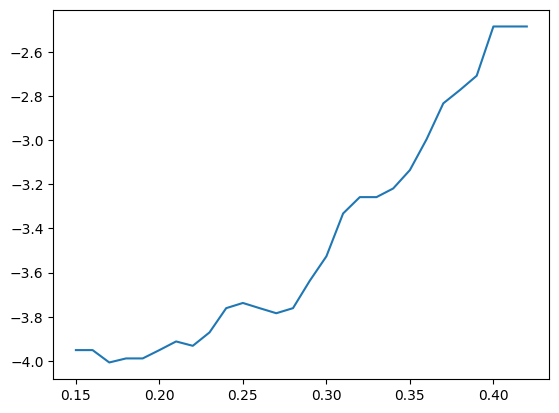

In [3]:
path = "/home/surayuth/her2/Data_Chula/HER2 2+ DISH- case 04/HER2 2 Neg DISH Case_4 (1).JPG"

img = read_image(path)
cont_mask = extract_mask(img)
n, deg, param_v, (x, y) = extract_line(cont_mask)
plt.plot(x, y)

In [16]:
deg = 3
params = np.polyfit(x, y, deg=deg)

In [17]:
yt = np.sum([p * x ** (deg-i) for i, p in enumerate(params)], axis=0)

In [18]:
ss_tot = ((y - y.mean()) ** 2).sum()
ss_res = ((y - yt.mean()) ** 2).sum()
rsq = 1 - ss_res / ss_tot

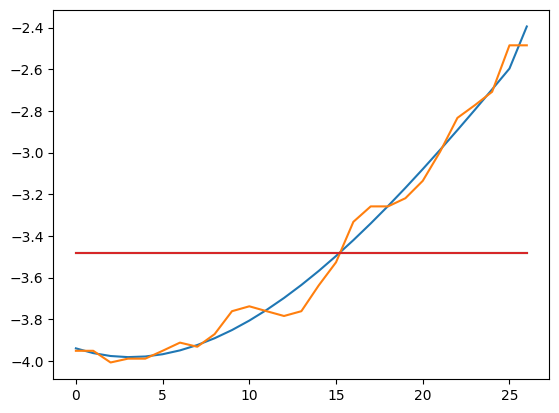

In [19]:
plt.plot(yt)
plt.plot(y)
plt.plot([yt.mean()] * len(x))
plt.plot([y.mean()] * len(x))